In [1]:
import numpy as np
import h5py
from types import SimpleNamespace
import matplotlib.pyplot as plt


In [2]:

with h5py.File("data/data.hdf5") as F:
    T = np.array(F["/T"])
    gridSizes = np.array(F["/gridSizes"])

    # Observables includes information for every grid size.
    Metropolis = SimpleNamespace(
        E=np.array(F["/Metropolis/E"]),
        M=np.array(F["/Metropolis/M"]),
        C=np.array(F["/Metropolis/C"]),
        X=np.array(F["/Metropolis/X"]),
    )

    Wolff = SimpleNamespace(
        E=np.array(F["/Wolff/E"]),
        M=np.array(F["/Wolff/M"]),
        C=np.array(F["/Wolff/C"]),
        X=np.array(F["/Wolff/X"]),
    )


## Derivation of the new Angle after Wolff flip

In [3]:
import sympy as sp

theta1, phi = sp.symbols("theta_1 phi")

# current spin angle
sx = sp.Matrix([sp.cos(theta1), sp.sin(theta1)])
# random reflection angle
r = sp.Matrix([sp.cos(phi), sp.sin(phi)])

# Wolff Formula
p = sx - 2 * (sx.dot(r))*r
p = sp.Matrix([p[0].simplify(), p[1].simplify()])

# Sign flipped = 180° phase shift
p

Matrix([
[-cos(2*phi - theta_1)],
[-sin(2*phi - theta_1)]])

# Metropolis

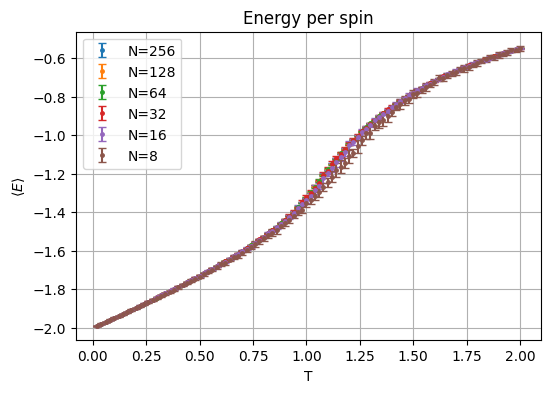

In [4]:
plt.figure(figsize=(6,4))
plt.tight_layout()
plt.title("Energy per spin")

for i,e in enumerate(Metropolis.E):
    plt.errorbar(T, e.mean(axis=0), e.std(axis=0), markersize=5, marker=".", linestyle='', capsize=3, label=f"N={gridSizes[i]}")
    # plt.plot(T, e.mean(axis=0), label=f"N={gridSizes[i]}")
    # plt.fill_between(T, e.mean(axis=0) - e.std(axis=0), e.mean(axis=0) + e.std(axis=0), alpha=0.25)

plt.legend()
plt.xlabel("T")
plt.ylabel(r"$\langle E \rangle$")
plt.grid()
# plt.savefig("../figs/Metropolis_E.pdf", bbox_inches='tight')
plt.show()

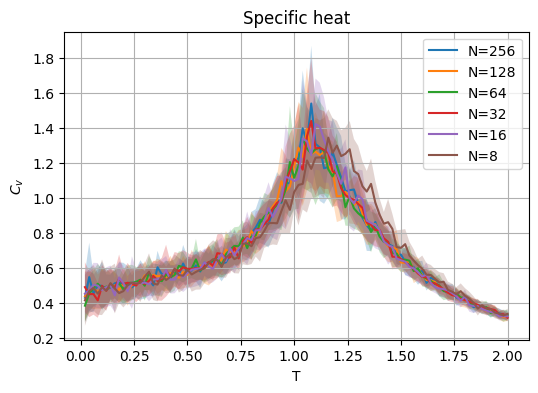

In [5]:
plt.figure(figsize=(6,4))
plt.tight_layout()
plt.title("Specific heat")

for i, c in enumerate(Metropolis.C):
    # plt.errorbar(T, c.mean(axis=0), c.std(axis=0), markersize=5, marker=".", linestyle='', capsize=3, label=f"N={gridSizes[i]}")
    plt.plot(T, c.mean(axis=0), label=f"N={gridSizes[i]}")
    plt.fill_between(T, c.mean(axis=0) - c.std(axis=0), c.mean(axis=0) + c.std(axis=0), alpha=0.25)

# plt.ylim([0, 10])
plt.legend()
plt.xlabel("T")
plt.ylabel(r"$C_v$")
plt.grid()
# plt.savefig("../figs/Metropolis_C.pdf", bbox_inches='tight')
plt.show()

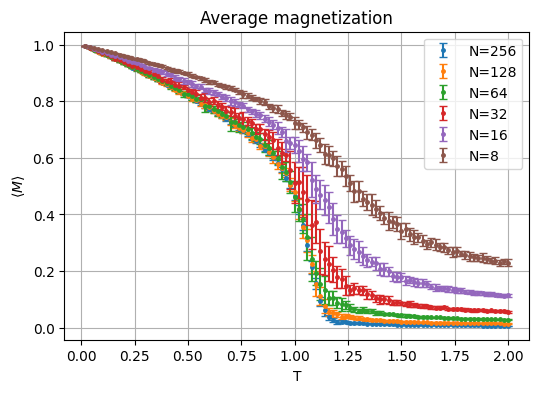

In [6]:
plt.figure(figsize=(6,4))
plt.tight_layout()
plt.title("Average magnetization")

for i, m in enumerate(Metropolis.M):
    plt.errorbar(T, m.mean(axis=0), m.std(axis=0), markersize=5, marker=".", linestyle='', capsize=3, label=f"N={gridSizes[i]}")
    # plt.plot(T, m.mean(axis=0), label=f"N={gridSizes[i]}")
    # plt.fill_between(T, m.mean(axis=0) - m.std(axis=0), m.mean(axis=0) + m.std(axis=0), alpha=0.25)

plt.legend()
plt.xlabel("T")
plt.ylabel(r"$\langle M \rangle$")
plt.grid()
# plt.savefig("../figs/Metropolis_M.pdf", bbox_inches='tight')
plt.show()

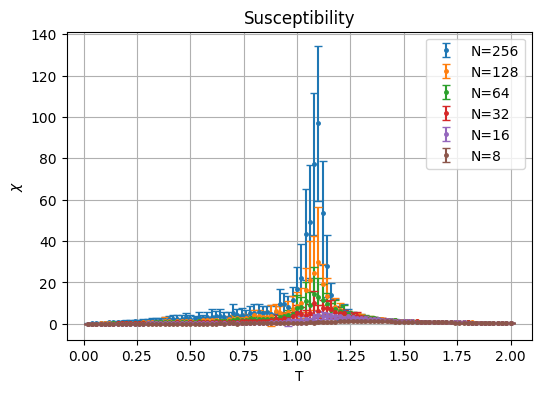

In [7]:
plt.figure(figsize=(6,4))
plt.tight_layout()
plt.title("Susceptibility")

for i, x in enumerate(Metropolis.X):
    plt.errorbar(T, x.mean(axis=0), x.std(axis=0), markersize=5, marker=".", linestyle='', capsize=3, label=f"N={gridSizes[i]}")
    # plt.plot(T, x.mean(axis=0), label=f"N={gridSizes[i]}")
    # plt.fill_between(T, x.mean(axis=0) - x.std(axis=0), x.mean(axis=0) + x.std(axis=0), alpha=0.25)

plt.legend()
plt.xlabel("T")
plt.ylabel(r"$\chi$")
plt.grid()
# plt.savefig("../figs/Metropolis_X.pdf", bbox_inches='tight')
plt.show()

# Wolff

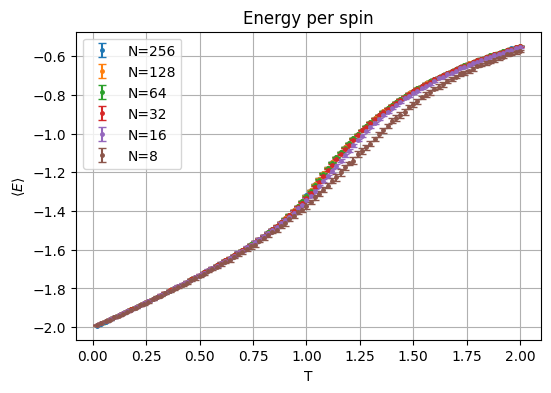

In [8]:
plt.figure(figsize=(6,4))
plt.tight_layout()
plt.title("Energy per spin")

for i,e in enumerate(Wolff.E):
    plt.errorbar(T, e.mean(axis=0), e.std(axis=0), markersize=5, marker=".", linestyle='', capsize=3, label=f"N={gridSizes[i]}")
    # plt.plot(T, e.mean(axis=0), label=f"N={gridSizes[i]}")
    # plt.fill_between(T, e.mean(axis=0) - e.std(axis=0), e.mean(axis=0) + e.std(axis=0), alpha=0.25)

plt.legend()
plt.xlabel("T")
plt.ylabel(r"$\langle E \rangle$")
plt.grid()
# plt.savefig("../figs/Wolff_E.pdf", bbox_inches='tight')
plt.show()

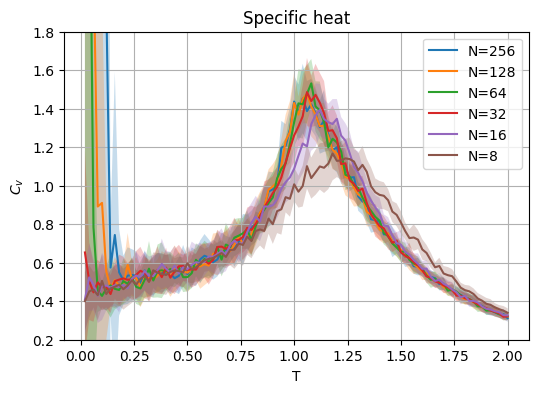

In [9]:
plt.figure(figsize=(6,4))
plt.tight_layout()
plt.title("Specific heat")

for i, c in enumerate(Wolff.C):
    # plt.errorbar(T, c.mean(axis=0), c.std(axis=0), markersize=5, marker=".", linestyle='', capsize=3, label=f"N={gridSizes[i]}")
    plt.plot(T, c.mean(axis=0), label=f"N={gridSizes[i]}")
    plt.fill_between(T, c.mean(axis=0) - c.std(axis=0), c.mean(axis=0) + c.std(axis=0), alpha=0.25)

plt.ylim([0.2, 1.8])
plt.legend()
plt.xlabel("T")
plt.ylabel(r"$C_v$")
plt.grid()
# plt.savefig("../figs/Wolff_C.pdf", bbox_inches='tight')
plt.show()

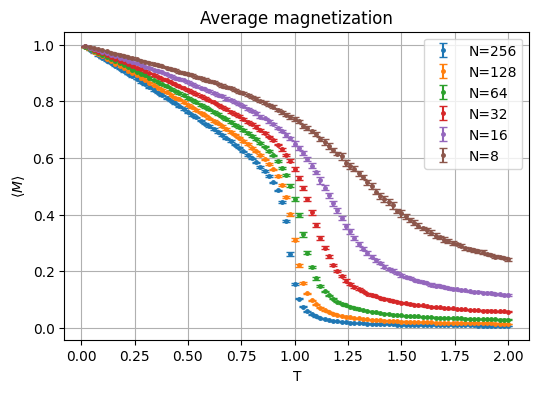

In [10]:
plt.figure(figsize=(6,4))
plt.tight_layout()
plt.title("Average magnetization")

for i, m in enumerate(Wolff.M):
    plt.errorbar(T, m.mean(axis=0), m.std(axis=0), markersize=5, marker=".", linestyle='', capsize=3, label=f"N={gridSizes[i]}")
    # plt.plot(T, m.mean(axis=0), label=f"N={gridSizes[i]}")
    # plt.fill_between(T, m.mean(axis=0) - m.std(axis=0), m.mean(axis=0) + m.std(axis=0), alpha=0.25)

plt.legend()
plt.xlabel("T")
plt.ylabel(r"$\langle M \rangle$")
plt.grid()
# plt.savefig("../figs/Wolff_M.pdf", bbox_inches='tight')
plt.show()

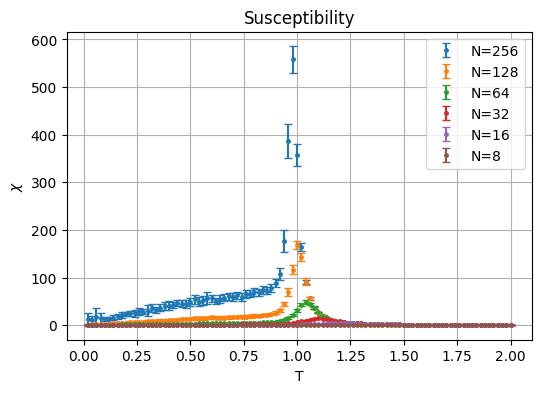

In [11]:
plt.figure(figsize=(6,4))
plt.tight_layout()
plt.title("Susceptibility")

for i, x in enumerate(Wolff.X):
    plt.errorbar(T, x.mean(axis=0), x.std(axis=0), markersize=5, marker=".", linestyle='', capsize=3, label=f"N={gridSizes[i]}")
    # plt.plot(T, x.mean(axis=0), label=f"N={gridSizes[i]}")
    # plt.fill_between(T, x.mean(axis=0) - x.std(axis=0), x.mean(axis=0) + x.std(axis=0), alpha=0.25)

plt.legend()
plt.xlabel("T")
plt.ylabel(r"$\chi$")
plt.grid()
# plt.savefig("../figs/Wolff_X.pdf", bbox_inches='tight')
plt.show()

# Data Collapse

$$
\chi(L, t) = L^{\gamma/\nu} \bar{\chi}(L e^{-b\cdot t^{-\nu}})
$$

/tmp/ipykernel_93900/3903060709.py:11: RuntimeWarning: invalid value encountered in power
  plt.plot(gridSizes[i]*np.exp(-b * ((T - Tc)/Tc)**(-nu) ), x.mean(axis=0) * gridSizes[i]**(-gamma/nu), label=f"L={gridSizes[i]}")


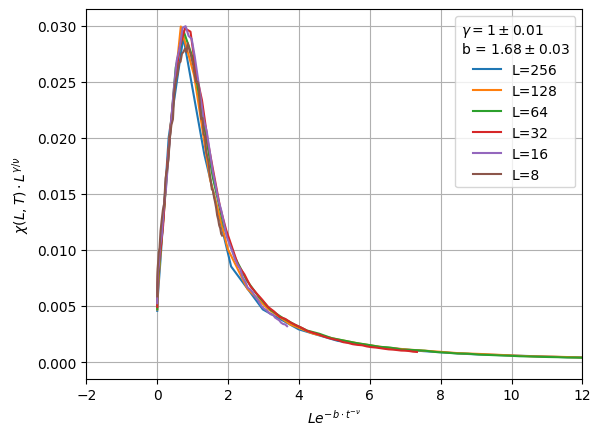

In [12]:
# https://arxiv.org/pdf/2109.10960
# Values taken from the fit below for Tc and nu
Tc = 0.884
nu = 0.562
# Estimated parameters by eye
gamma = 1
b = 1.68

# There might be negative values of t unter the n-th root.
for i, x in enumerate(Wolff.X):
    plt.plot(gridSizes[i]*np.exp(-b * ((T - Tc)/Tc)**(-nu) ), x.mean(axis=0) * gridSizes[i]**(-gamma/nu), label=f"L={gridSizes[i]}")

plt.xlim([-2, 12])
plt.xlabel(r"$L e^{-b\cdot t^{-\nu}}$")
plt.ylabel(r"$\chi (L,T) \cdot L^{\gamma / \nu}$")
plt.legend(title="$\\gamma = 1 \\pm 0.01$\nb = $1.68 \\pm 0.03$")
plt.grid()
# plt.savefig("../figs/Data_Collapse_X.pdf", bbox_inches='tight')
plt.show()

In [13]:
# Some additional data for more grid sizes has been added later.
# Added grid sizes: {12, 24, 48}
# Generated using main.cpp, but with changed grid sizes.
# Purpose was a better line fit / improve normalized chi-squared

with h5py.File("data/add_gridpoints.hdf5") as F:
    BiggergridSizes = np.concatenate((gridSizes, np.array(F["/gridSizes"])))

    # Observables includes information for every grid size.
    BiggerMetropolis = SimpleNamespace(
        E=np.concatenate((Metropolis.E, np.array(F["/Metropolis/E"]).transpose((0,2,1)))),
        M=np.concatenate((Metropolis.M, np.array(F["/Metropolis/M"]).transpose((0,2,1)))),
        C=np.concatenate((Metropolis.C, np.array(F["/Metropolis/C"]).transpose((0,2,1)))),
        X=np.concatenate((Metropolis.X, np.array(F["/Metropolis/X"]).transpose((0,2,1)))),
    )

    BiggerWolff = SimpleNamespace(
        E=np.concatenate((Wolff.E, np.array(F["/Wolff/E"]).transpose((0,2,1)))),
        M=np.concatenate((Wolff.M, np.array(F["/Wolff/M"]).transpose((0,2,1)))),
        C=np.concatenate((Wolff.C, np.array(F["/Wolff/C"]).transpose((0,2,1)))),
        X=np.concatenate((Wolff.X, np.array(F["/Wolff/X"]).transpose((0,2,1)))),
    )

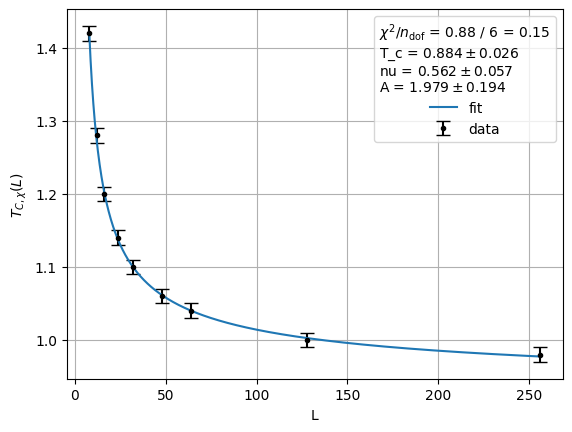

In [14]:
import iminuit
from iminuit.cost import LeastSquares

# Determine the temperatures where susceptibility peaks
peaks = [T[np.argmax(BiggerWolff.X[i].mean(axis=0))] for i in range(len(BiggergridSizes))]
peaks_error = np.full_like(peaks, 0.01) # temperature resolution, related to how we defined our temperature grid

# https://arxiv.org/pdf/2109.10960
def line(L, T_c, nu, A):
    return T_c + A * np.log(L)**(-1/nu)

least_squares = LeastSquares(BiggergridSizes, peaks, peaks_error, line)
m = iminuit.Minuit(least_squares, T_c = 1, nu = 1, A = 1)
m.migrad()
m.hesse()


plt.errorbar(BiggergridSizes, peaks, peaks_error, fmt="ok", capsize=5, markersize=3, label="data")
l = np.linspace(BiggergridSizes.min(), BiggergridSizes.max(), 1000)
plt.plot(l, line(l, *m.values), label="fit")

# display legend with some fit info
fit_info = [
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.2f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.2f}",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.legend(title="\n".join(fit_info))
plt.xlabel("L")
plt.ylabel(r"$T_{C, \chi} (L)$")
plt.grid()
# plt.savefig("../figs/TC_fit.pdf", bbox_inches='tight')
plt.show()

# Autocorrelation time

In [15]:
# !cd build/ && make && ./xy_serial

In [16]:
with h5py.File("data/ac-times.hdf5") as F:
    gridSizes = np.array(F["/grid"])
    T = np.array(F["/T"])
    tau = np.array(F["Metropolis/C"])
    tau_w = np.array(F["Wolff/C"])

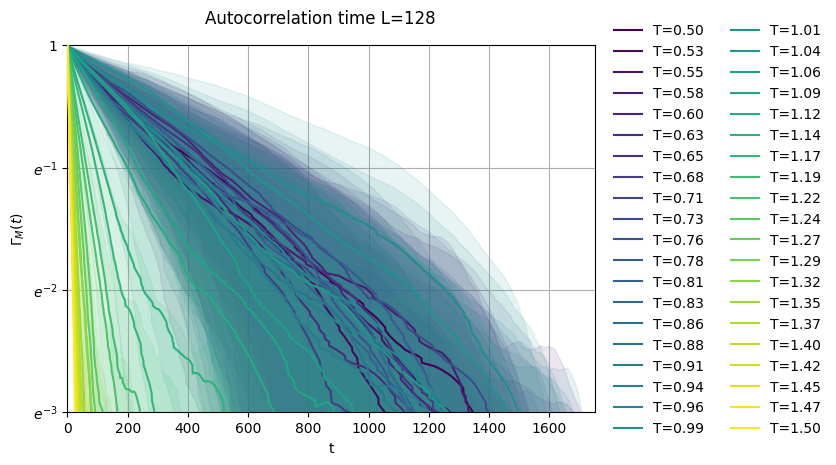

In [17]:

fig, ax = plt.subplots(figsize=(6,4.5))
fig.tight_layout()
fig.suptitle(f"Autocorrelation time L={gridSizes[-1]:.0f}")
plt.subplots_adjust(top=0.9)

for i, t in enumerate(tau[-1]):
    plt.plot(t.mean(axis=0), label=f"T={T[i]:.2f}", c=plt.cm.viridis(i/(len(tau[0-1])-1)), zorder=5)
    plt.fill_between(np.arange(t.shape[1]), t.mean(axis=0) - t.std(axis=0), t.mean(axis=0) + t.std(axis=0),
                     color=plt.cm.viridis(i/(len(tau[-1])-1)), alpha=0.1, zorder=4)

ax.legend(bbox_to_anchor=(1.0125, -0.1), ncol=2, frameon=False)
ax.set_xlabel("t")
ax.set_ylabel(r"$\Gamma_M (t)$")

ax.set_xlim([0, 1750])
ax.set_yscale("log", base=np.e)
ax.set_ylim([np.exp(-3), 1])
ax.set_yticks([np.exp(0), np.exp(-1), np.exp(-2), np.exp(-3)])
ax.set_yticklabels(['1', '$e^{-1}$', '$e^{-2}$', '$e^{-3}$'])
ax.grid()
# plt.savefig("../figs/Autocorrelation_Metropolis.pdf", bbox_inches='tight')
plt.show()

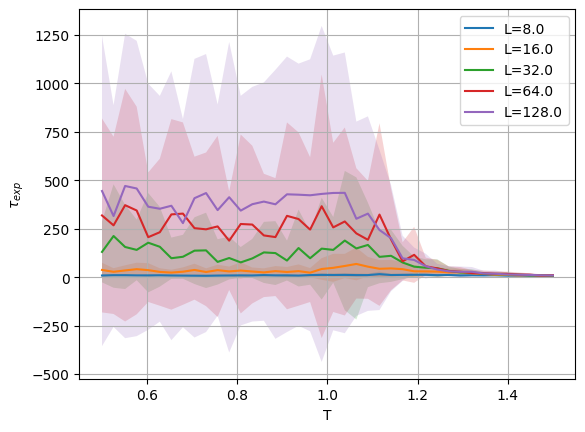

In [18]:

for L in range(len(tau)):
    max_taus = np.zeros(tau[L].shape[0])
    var_max_taus = np.zeros(tau[L].shape[0])

    for i, t in enumerate(tau[L]):
        # Cannot do exponential LS-fitting using iMinuit,
        # since the Hessian is not positive definite.

        t1 = np.argmax(t.mean(axis=0) < np.exp(-1))
        # Project upper and lower bounds onto step axis
        t1_minus = np.argmax(t.mean(axis=0) - t.std(axis=0) < np.exp(-1))
        t1_plus = np.argmax(t.mean(axis=0) + t.std(axis=0) < np.exp(-1))

        t3 = np.argmax(t.mean(axis=0) < np.exp(-3))
        # Project upper and lower bounds onto step axis
        t3_minus = np.argmax(t.mean(axis=0) - t.std(axis=0) < np.exp(-2))
        t3_plus = np.argmax(t.mean(axis=0) + t.std(axis=0) < np.exp(-2))

        max_taus[i] = (t3 - t1) / 2
        # Gaussian error propagation for t1 and t3
        var_max_taus[i] = np.sqrt((t1_plus - t1_minus)**2 / 2 + (t3_plus - t3_minus)**2 / 2)

    # plt.errorbar(T, max_taus, var_max_taus, marker="o", markersize=3, capsize=5, label=f"L={gridSizes[L]}")
    plt.plot(T, max_taus, label=f"L={gridSizes[L]}")
    plt.fill_between(T, max_taus - var_max_taus, max_taus + var_max_taus, alpha=0.2)

plt.legend()
plt.xlabel("T")
plt.ylabel(r"$\tau_{exp}$")
plt.grid()
# plt.savefig("../figs/Autocorrelation_time_Metropolis.pdf", bbox_inches='tight')
plt.show()

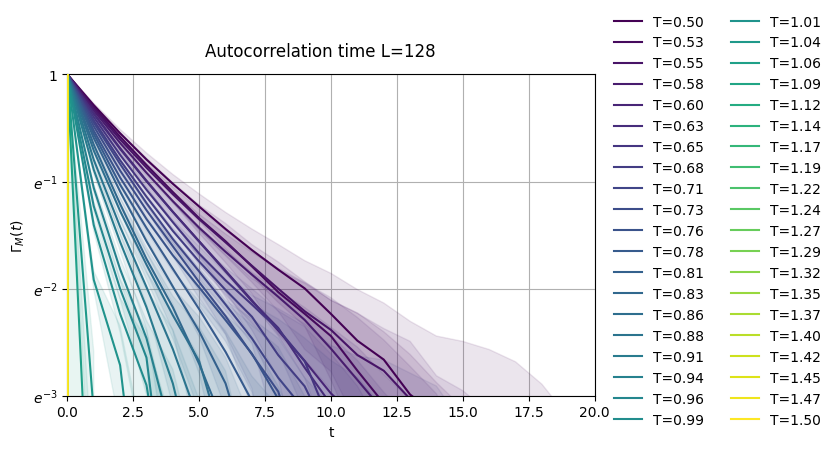

In [19]:

fig, ax = plt.subplots(figsize=(6,4))
fig.tight_layout()
fig.suptitle(f"Autocorrelation time L={gridSizes[-1]:.0f}")
plt.subplots_adjust(top=0.9)

for i, t in enumerate(tau_w[-1]):
    plt.plot(t.mean(axis=0), label=f"T={T[i]:.2f}", c=plt.cm.viridis(i/(len(tau_w[0])-1)), zorder=5)
    plt.fill_between(np.arange(t.shape[1]), t.mean(axis=0) - t.std(axis=0), t.mean(axis=0) + t.std(axis=0),
                     color=plt.cm.viridis(i/(len(tau_w[0])-1)), alpha=0.1, zorder=4)

ax.legend(bbox_to_anchor=(1.0125, -0.135), ncol=2, frameon=False)
ax.set_xlabel("t")
ax.set_ylabel(r"$\Gamma_M (t)$")

ax.set_xlim([0, 20])
ax.set_yscale("log", base=np.e)
ax.set_ylim([np.exp(-3), 1])
ax.set_yticks([np.exp(0), np.exp(-1), np.exp(-2), np.exp(-3)])
ax.set_yticklabels(['1', '$e^{-1}$', '$e^{-2}$', '$e^{-3}$'])
ax.grid()

# plt.savefig("../figs/Autocorrelation_Wolff.pdf", bbox_inches='tight')
plt.show()

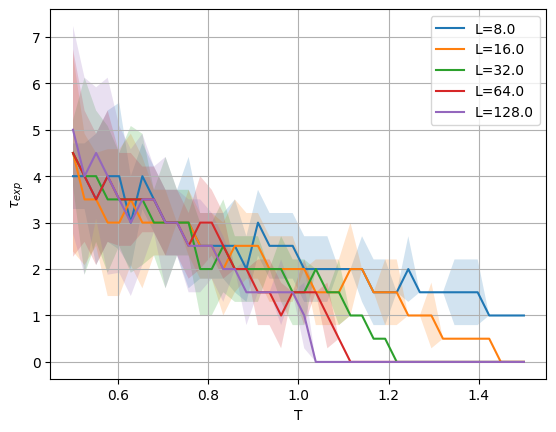

In [20]:
for L in range(len(tau_w)):
    max_taus = np.zeros(tau_w[L].shape[0])
    var_max_taus = np.zeros(tau_w[L].shape[0])

    for i, t in enumerate(tau_w[L]):
        t1 = np.argmax(t.mean(axis=0) < np.exp(-1))
        # Project upper and lower bounds onto step axis
        t1_minus = np.argmax(t.mean(axis=0) - t.std(axis=0) < np.exp(-1))
        t1_plus = np.argmax(t.mean(axis=0) + t.std(axis=0) < np.exp(-1))

        t3 = np.argmax(t.mean(axis=0) < np.exp(-3))
        # Project upper and lower bounds onto step axis
        t3_minus = np.argmax(t.mean(axis=0) - t.std(axis=0) < np.exp(-2))
        t3_plus = np.argmax(t.mean(axis=0) + t.std(axis=0) < np.exp(-2))

        max_taus[i] = (t3 - t1) / 2
        # Gaussian error propagation for t1 and t3
        var_max_taus[i] = np.sqrt((t1_plus - t1_minus)**2 / 2 + (t3_plus - t3_minus)**2 / 2)

    # plt.errorbar(T, max_taus, var_max_taus, marker="o", markersize=3, capsize=5, label=f"L={gridSizes[L]}")
    plt.plot(T, max_taus, label=f"L={gridSizes[L]}")
    plt.fill_between(T, max_taus - var_max_taus, max_taus + var_max_taus, alpha=0.2)

plt.legend()
plt.xlabel("T")
plt.ylabel(r"$\tau_{exp}$")
plt.grid()
# plt.savefig("../figs/Autocorrelation_time_Wolff.pdf", bbox_inches='tight')
plt.show()